In [1]:
import sys
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

color_dict = {'Thy1-GC6s; Cdh23 (Ahl/ahl)':"#DD0000",'Thy1-GC6s; Cdh23 (ahl/ahl)':'#000000','(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)':'#FFCC00'}
order = ['Thy1-GC6s; Cdh23 (ahl/ahl)','(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)','Thy1-GC6s; Cdh23 (Ahl/ahl)']

##import 
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
import utils
import plotting
import responses_analysis
import importlib
import dfof
import numpy as np
from response2p.bandwidth import bandwidth as bw
from response2p.bestFrequency import bestFrequency as bf
from response2p.characteristicFrequency import characteristicFrequency as cf
from response2p.respondsToFreqs import respondsToFreqs as rFreqs
from response2p.responseStats import getResponses, responseStats
import stats

importlib.reload(responses_analysis)
importlib.reload(plotting)

save_path = Path("Panels")
data_path = Path("D:/Travis/Cdh23")
if not save_path.exists():
    save_path.mkdir()

import utils
from pathlib import Path
import pickle 

home = Path("D:\Travis\Cdh23\Cdh23 Data")

In [2]:
sig_responding_neurons = []
total_neurons = []
meancorrs = []
noisecorrs = []
onset_proportion = [] 
offset_proportion = []
onset_offset_proportion = []

force = False

test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)
responseProperties = pd.DataFrame()

for index, row in twop_mice.iterrows():
    print(row['Mouse'])
    analysis_dir = row['2P_path'] / "response_analysis"
    if not analysis_dir.exists():
        (row['2P_path'] / "response_analysis").mkdir()

    if (analysis_dir / "unmixed.npy").exists():
        unmixed = np.load(analysis_dir / "unmixed.npy")
    else:
        temp = dfof.processFluor(dir = row['2P_path'])
        temp.loadTraces()
        temp.calc_dfof(window=500, step = 50, percentile=10, cutoff = 20)
        temp.unmix(numBaseline=15, framesAfter=60)
        np.save(analysis_dir / "unmixed.npy", temp.unmixed)

    responsive_file = analysis_dir / "isResponsive_with_offset.csv"
    if responsive_file.exists() and not force:
        isResponsive = pd.read_csv(responsive_file)
    else:
        isResponsive = responses_analysis.isResponsive_withoffset(unmixed, alpha = 0.01)
        isResponsive.to_csv(responsive_file, index=False)

    classification_file = analysis_dir / "onset_offset_classification.csv"
    if classification_file.exists() and not force:
        classification = pd.read_csv(classification_file)
    else:
        responses = responses_analysis.getResponses(unmixed, [(0,15),(20,24),(26,30)])
        responses = responses.merge(isResponsive[isResponsive['isResponsive']==True], on="neuron")
        classification = responses_analysis.onset_offset_classification(responses)
        classification.to_csv(classification_file, index=False)
        
    onset_offset_prop = classification['Classification'].value_counts(normalize=True)

    onset_proportion.append(onset_offset_prop['Onset'])
    offset_proportion.append(onset_offset_prop['Offset'])
    onset_offset_proportion.append(onset_offset_prop['Onset/Offset'])
    sig_responding_neurons.append(isResponsive['isResponsive'].value_counts().loc[True])
    total_neurons.append(isResponsive.shape[0])
    
twop_mice['total_neurons'] = total_neurons
twop_mice['sig_responders'] = sig_responding_neurons
twop_mice['sound_responsive_percent'] = twop_mice['sig_responders'] / twop_mice['total_neurons'] * 100
twop_mice['onset_prop'] = onset_proportion
twop_mice['offset_prop'] = offset_proportion
twop_mice['onset_offset_prop'] = onset_offset_proportion

**/2P/L23/[0-9]* all
m602
m603
m609
m670
m674
m675
m659
m722
m664
m666
m900
m984
m985
m1315
m1321
m1318
m1323
m1493
m1937
m2065
m1983


C:\Users\travisb\AppData\Local\Temp\ipykernel_12020\3857100165.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['ahl B6','Ahl+ B6','Ahl+\nCBA.B6'], ha='center',x=-.15)


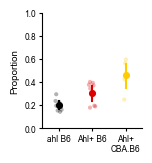

In [12]:
##Just offset proportion

import seaborn as sns

np.random.seed(42)
order = ['Thy1-GC6s; Cdh23 (ahl/ahl)','Thy1-GC6s; Cdh23 (Ahl/ahl)','(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
fig, ax = plt.subplots(figsize=(1.3,1.5))
twop_mice["total_offset_prop"] = twop_mice["offset_prop"] + twop_mice["onset_offset_prop"]
sns.pointplot(twop_mice, x="Genotype", y = "total_offset_prop", hue = "Genotype", order = order, palette=color_dict, markersize=4, linewidth = 1.5)
#sns.boxplot(twop_mice, x="Genotype", y = "total_offset_prop", hue = "Genotype", order = order, palette=color_dict, fill = False, saturation=0.75, width = 0.25, linewidth=0.75, showcaps=False)
sns.stripplot(twop_mice, x="Genotype", y = "total_offset_prop", hue = "Genotype", marker='o', size=3, legend = None, palette=color_dict, alpha = 0.3)

plt.ylim([0,1])
plt.ylabel("Proportion", fontsize=7)
plt.xlabel("")
ax.set_xticklabels(['ahl B6','Ahl+ B6','Ahl+\nCBA.B6'], ha='center',x=-.15)
fig, ax = plotting.figQuality(fig, ax)

plt.savefig(save_path / "SF3A_offset_proportion.svg")

In [10]:
#stats
model = ols('total_offset_prop ~ C(Genotype) + C(Sex) + C(Genotype):C(Sex)', data=twop_mice).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(Genotype),0.210556,2.0,11.261965,0.001031
C(Sex),0.000167,1.0,0.017838,0.895526
C(Genotype):C(Sex),0.022163,2.0,1.185407,0.332685
Residual,0.140222,15.0,NaN,NaN


In [9]:
stats.ttests_2(twop_mice, dv_cat="total_offset_prop")

,geno1,geno2,pval,reject_hs,pval_corrected
0,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),0.016978,True,0.025467
1,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),0.037411,True,0.037411
2,Thy1-GC6s; Cdh23 (ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),0.000412,True,0.001236
